In [1]:
# my modules imports
from model import SEIR
from utils import draw_input_params

# other imports
from pprint import pprint
import numpy as np
from scipy.integrate import RK45, odeint
import matplotlib.pyplot as plt

# bokeh plotting
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import PrintfTickFormatter
from bokeh.models import CustomJS, DateRangeSlider
from bokeh.models import Legend
output_notebook(hide_banner=True)

from ipywidgets import interact, IntSlider, Dropdown, FloatSlider


In [2]:
debug = True
seed = 1111

In [3]:
if(debug):
    x = draw_input_params(seed)
    model = SEIR(x)
    model.prettyprint()
    model.step(dt = 1.0) # dt in days 
    model.prettyprint()

============== SEIR MODEL ==============
----------- input parameters -----------
OrderedDict([('pa', 0.44777459960438104),
             ('pIH', 0.18875055527924495),
             ('pIU', 0.020307202696216567),
             ('pHD', 0.13104769418698442),
             ('pHU', 0.10020098399490976),
             ('pUD', 0.2471189448783151),
             ('NI', 8.951166880633519),
             ('NH', 22.359158732407092),
             ('NU', 14.954680759619642),
             ('R0', 3.2922126744045577),
             ('mu', 0.018855441784553242),
             ('N', 50),
             ('t0', 10),
             ('Im0', 47.1459765189812),
             ('lambda1', 0.003134189119522501)])
---------------- Rates -----------------
OrderedDict([('gIR', 0.09881985306407182),
             ('gIH', 0.011644610401521123),
             ('gIU', 0.0012528146653254559),
             ('gHD', 0.005861029735302406),
             ('gHU', 0.004481429073164532),
             ('gHR', 0.03438194303365658),
             

In [4]:
ykeys = {
        'S' : 0,
        'Im' : 1,
        'Ip' : 2,
        'Rm' : 3,
        'RI' : 4,
        'H' : 5,
        'U' : 6,
        'RH' : 7,
        'D' : 8,
        'DR' : 9
    }

def post_processing(solution, dt):
    # order : S, Im, Ip, Rm, RI, H, U, RH, D, DR
    max_it = np.argmax(solution[:,ykeys['U']])
    max_U = solution[max_it,ykeys['U']]
    max_time = max_it*dt
    return int(max_time), int(max_U)
    
    
def plot_solution(seed = None):
    x = draw_input_params(seed)
    model = SEIR(x)
    model.prettyprint()
    
    fcn = model.get_fcn()
    y_ini = model.get_state()
    # in number of days
    tini = 0.
    tend = 200.0
    max_step = 1000

    t = np.linspace(tini,tend,max_step)
    step = (tend-tini)/max_step
    
    rtol, atol = 1e-3, 1e-6 # default values

    sol = odeint(func = fcn, t = t, y0 = y_ini)    
    
    max_time, max_U = post_processing(sol, step)
    print('Max intensive care load at days {} with {} patients.'.format(max_time, max_U))

    names = ['Susceptible', 'Infected - Not detected', 'Infected - Detected', 'Recovered - Not detected', \
             'Recovered - Detected - No Hospital', 'In Hospital', 'In Intensive Care', 'Recovered - from Hospital', 'Dead', 'Number of new cases (DR)']
    colors = ['blue', 'orange', 'red', 'cyan', 'green', 'pink', 'purple', 'brown', 'black', 'yellow'] # https://www.geeksforgeeks.org/python-bokeh-colors-class/
    
    fig_sol = figure(x_range=(tini, tend), plot_height=450, plot_width=900, title="Solution")
    
    
    
    legend_it = []
    for idx, name in enumerate(names):
        c = fig_sol.x(t, sol[:,idx], line_width=1, color = colors[idx], alpha=0.9, muted_color=colors[idx], muted_alpha=0.01) # legend_label="Speed")
        legend_it.append((name, [c]))
        
    legend = Legend(items=legend_it)
    legend.click_policy="mute"
    fig_sol.add_layout(legend, 'right')
    #show(column(fig_sol_speed), notebook_handle=True)

    show(fig_sol, notebook_handle=True)
    

In [5]:
plot_solution()

============== SEIR MODEL ==============
----------- input parameters -----------
OrderedDict([('pa', 0.6786127888892368),
             ('pIH', 0.16406252586426634),
             ('pIU', 0.014803724399895666),
             ('pHD', 0.13576899425877043),
             ('pHU', 0.19432028511660843),
             ('pUD', 0.2024968189356438),
             ('NI', 10.264471826912214),
             ('NH', 23.808230861641768),
             ('NU', 16.540364264573455),
             ('R0', 2.9448193931608095),
             ('mu', 0.015796291659188826),
             ('N', 31),
             ('t0', 23),
             ('Im0', 27.44530832479356),
             ('lambda1', 0.0022912774098751577)])
---------------- Rates -----------------
OrderedDict([('gIR', 0.09182300760908133),
             ('gIH', 0.005136903147520808),
             ('gIU', 0.0004635141270942586),
             ('gHD', 0.005702607432184824),
             ('gHU', 0.008161895196912102),
             ('gHR', 0.028137778254827682),
          

In [9]:
def Monte_Carlo(N = 100):
    list_U = []
    list_times = []
    
    for k in range(N): 
        x = draw_input_params()
        model = SEIR(x)

        fcn = model.get_fcn()
        y_ini = model.get_state()
        # in number of days
        tini = 0.
        tend = 365.0
        max_step = 1000

        t = np.linspace(tini,tend,max_step)
        step = (tend-tini)/max_step

        rtol, atol = 1e-3, 1e-6 # default values

        sol = odeint(func = fcn, t = t, y0 = y_ini)    

        max_time, max_U = post_processing(sol, step)
        list_U.append(max_U)
        list_times.append(max_time)
        
    plt.hist(list_U)
    plt.show()
    plt.hist(list_times)
    plt.show()


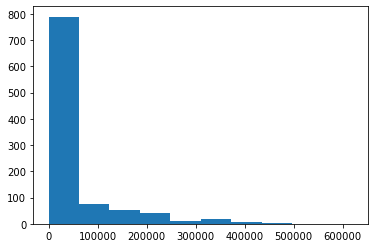

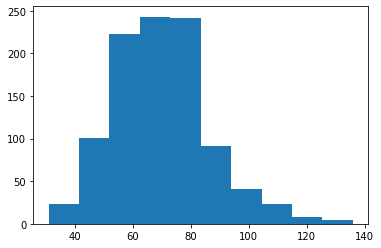

In [10]:
Monte_Carlo(N=100)